In [10]:
using Distributions
using Statistics
using Roots
using Plots

In [11]:
N = 10000 # number of total observations

10000

In [12]:
H = exp(0.1) # external validity param
K = exp(0.5) # latent-unconfoundedness param

1.6487212707001282

In [13]:
U = rand(Normal(), N);

In [14]:
S₁ = 5 * (rand(N) .< (0.5 .- 0.3*(U.>0))) .+ 5;
histogram(S₁, leg = false);

In [15]:
G = rand(N) .> (1 ./ (1 .+ exp.(-log(H).* (U.>0))));
histogram(G); # G = 1 for experimental units

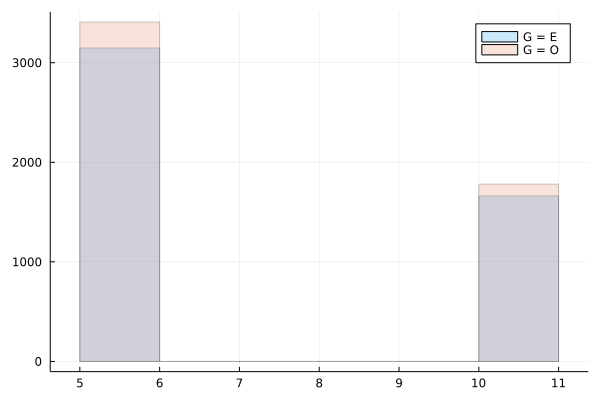

In [16]:
histogram(S₁[G .== 1], label = "G = E", alpha = 0.2)
histogram!(S₁[G .== 0], label = "G = O", alpha = 0.2)

In [17]:
using DataFrames

In [18]:
df = DataFrame(G = G, S1 = S₁);
gdf = groupby(df, :G);
combine(gdf, :S1 => mean)

,G,S1_mean
,Bool,Float64
1,1,6.72765
2,0,6.7158


In [19]:
V = rand(Normal(), N);

In [20]:
Y₁ = S₁ + V + randn(N);
mean(Y₁)

6.74820222886905

In [21]:
D = similar(G);

In [22]:
D[G .== 1] = rand((0,1), sum(G .== 1)); # randomization in the experimental sample
D[G .== 0] = rand(sum(G .== 0)) .> (1 ./ (1 .+ exp.(-log(K).* (V[G .== 0].>0) .- 0.1 .*S₁[G .== 0]))); # K-latent-confoundedness

In [23]:
df = DataFrame(G = G, S1 = S₁, D=D, Y1 = Y₁, S = D.*S₁, Y = D.*Y₁)

,G,S1,D,Y1,S,Y
,Bool,Int64,Bool,Float64,Int64,Float64
1,1,10,1,10.8768,10,10.8768
2,1,5,1,5.89644,5,5.89644
3,1,5,0,5.59183,0,0.0
4,1,5,1,2.91205,5,2.91205
5,1,5,1,7.53401,5,7.53401
6,0,5,0,5.45602,0,0.0
7,0,5,1,8.35934,5,8.35934
8,0,10,0,11.6997,0,0.0
9,1,5,1,5.00446,5,5.00446


In [24]:
ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)

ϕ′ (generic function with 1 method)

In [25]:
f(m) = mean((df.D .== 1) .* (df.G .== 1) .* ϕ(m, df.S))
g(m) = mean((df.D .== 1) .* (df.G .== 1) .* ϕ′(m, df.S))

g (generic function with 1 method)

In [26]:
find_zero(f, 2.0)

6.637921374299191

In [27]:
find_zero(g, 2.0)

6.865276774686964

In [28]:
ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)

ψ′ (generic function with 1 method)

In [29]:
f(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
g(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))

g (generic function with 1 method)

In [30]:
θ1hat_s1 = find_zero(f(5), 2.0)

4.574905667208948

In [31]:
θ1hat_s2 = find_zero(f(10), 2.0)

9.530545992998208

In [32]:
lower(m) = mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ(m, θ1hat_s1)) + mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ(m, θ1hat_s2)) 

lower (generic function with 1 method)

In [33]:
find_zero(lower, 2.0)

6.198295509798796

In [34]:
mean(df[df.G .== 0, :Y1])

6.732283997929555

In [35]:
mean(df[ (df.G .== 0) .* (df.D .== 1), :Y])

6.1073374831889975

## Wrapping things up

In [36]:
using Distributions
using Statistics
using Roots
using Plots
using DataFrames

In [37]:
function data_generation(N = 10000; H = exp(0.1), K = exp(0.5))
    N = 10000 # number of total observations
    
    # unobserved confounder for external validity
    U = rand(Normal(), N)
    
    # DGP for S₁ and G. They all depend on U.
    S₁ = 5 * (rand(N) .< (0.5 .- 0.3*(U.>0))) .+ 5 
    G = rand(N) .> (1 ./ (1 .+ exp.(-log(H).* (U.>0)))); 
    
    # unobserved confounder for latent unconfoundedness
    V = rand(Normal(), N);
    
    # DGP for Y₁ and D. They all depend on V.
    Y₁ = S₁ + V + randn(N);
    D = similar(G);
    
    # randomization in the experimental sample
    D[G .== 1] = rand((0,1), sum(G .== 1))
    
    # K-latent-confoundedness
    D[G .== 0] = rand(sum(G .== 0)) .> 
    (1 ./ (1 .+ exp.(-log(K).* (V[G .== 0].>0) .- 0.1 .*S₁[G .== 0])))
    
    df = DataFrame(G = G, S1 = S₁, D=D, Y1 = Y₁, S = D.*S₁, Y = D.*Y₁)
end

data_generation (generic function with 2 methods)

In [38]:
df = data_generation(10000)

,G,S1,D,Y1,S,Y
,Bool,Int64,Bool,Float64,Int64,Float64
1,1,5,0,5.55773,0,0.0
2,1,10,0,8.94009,0,0.0
3,0,5,1,8.16212,5,8.16212
4,1,5,1,4.5757,5,4.5757
5,0,5,0,5.8622,0,0.0
6,1,5,1,4.83542,5,4.83542
7,1,5,1,5.16341,5,5.16341
8,0,5,0,3.69773,0,0.0
9,0,10,1,8.66727,10,8.66727


In [39]:
function lower(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ1minushat_s1 = find_zero(f(5), 2.0)
    θ1minushat_s2 = find_zero(f(10), 2.0)
    
    return mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ(m, θ1minushat_s1)) + mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ(m, θ1minushat_s2)) 
end

lower (generic function with 1 method)

In [40]:
function upper(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ1plushat_s1 = find_zero(g(5), 2.0)
    θ1plushat_s2 = find_zero(g(10), 2.0)
    
    return mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ′(m, θ1plushat_s1)) + mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ′(m, θ1plushat_s2)) 
end

upper (generic function with 1 method)

In [41]:
ϕ(x, y; H = 1) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
ϕ′(x, y; H = 1) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
ψ(x, y; K = 1) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
ψ′(x, y; K = 1) = max.(x .- y, 0) .- K .* max.(y .- x, 0)

ψ′ (generic function with 1 method)

In [42]:
function compute_lower_Y1(df; K=1, H=1)
    
    f(s; df = df, K = K) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y; K = K))
    
    θ1minushat_s1 = find_zero(f(5; df = df, K=K), 2.0)
    θ1minushat_s2 = find_zero(f(10; df = df, K=K), 2.0)
    
    μ1minus = find_zero(m -> lower(m; df=df, K=K, H=H), 2.0) / mean(df[df.G .== 0, :D].== 0) - 
    (θ1minushat_s1 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 5) + 
    θ1minushat_s2 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 1) /
    mean(df[df.G .== 0, :D].== 0)
    
    lower_Y1 = mean(df[ (df.G .== 0) .* (df.D .== 1 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 1) +  
        μ1minus* 
        mean(df[df.G .== 0, :D].== 0)
end

compute_lower_Y1 (generic function with 1 method)

In [43]:
compute_lower_Y1(df)

6.655590408154372

In [44]:
function compute_upper_Y1(df; K = exp(0.5), H = exp(0.1))
    
    g(s; df = df, K = K) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y; K = K))
    
    θ1plushat_s1 = find_zero(g(5; df = df, K = K), 2.0)
    θ1plushat_s2 = find_zero(g(10; df = df, K = K), 2.0)
    
    μ1plus = find_zero(m -> upper(m; df=df, K=K, H=H), 2.0) / mean(df[df.G .== 0, :D].== 0) - (θ1plushat_s1 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 5) + 
    θ1plushat_s2 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 1) /
    mean(df[df.G .== 0, :D].== 0)
    
    upper_Y1 = mean(df[ (df.G .== 0) .* (df.D .== 1 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 1) +  
        μ1plus* 
        mean(df[df.G .== 0, :D].== 0)
end

compute_upper_Y1 (generic function with 1 method)

In [45]:
compute_upper_Y1(df)

6.971281562855371

In [46]:
naive_mean = compute_lower_Y1(df; K=1, H =1)

6.655590408154372

In [47]:
df = data_generation();

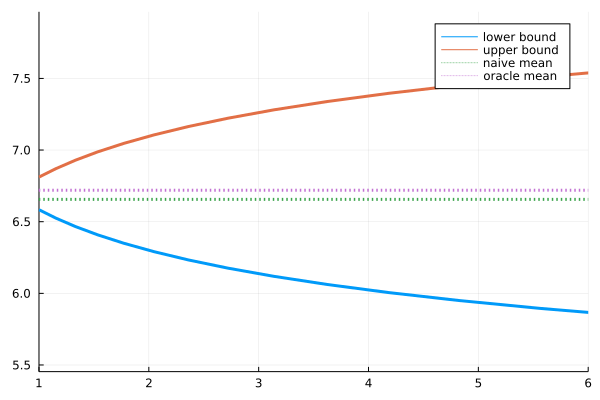

In [48]:
Ks = exp.(LinRange(0.0, exp(1), 20))
plot(Ks, [compute_lower_Y1(df; K=K, H =exp(0.1)) for K in Ks], xlim = (1, 6), label = "lower bound", lw = 3)
plot!(Ks, [compute_upper_Y1(df; K=K, H =exp(0.1)) for K in Ks], label = "upper bound", lw = 3)
plot!(leg = :best)
hline!([naive_mean], label = "naive mean", linestyle = :dot, lw = 3)
hline!([mean(df[df.G .== 0, :Y1])], label = "oracle mean", linestyle = :dot, lw = 3)

In [49]:
function lower2(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ0minushat_s1 = find_zero(f(5), 0.0)
    θ0minushat_s2 = find_zero(f(10), 0.0)
    
    return mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ(m, θ0minushat_s1)) + mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ(m, θ0minushat_s2)) 
end

lower2 (generic function with 1 method)

In [50]:
function upper2(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ0plushat_s1 = find_zero(g(5), 0.0)
    θ0plushat_s2 = find_zero(g(10), 0.0)
    
    return mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ′(m, θ0plushat_s1)) + mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ′(m, θ0plushat_s2)) 
end

upper2 (generic function with 1 method)

In [51]:
function compute_lower_Y0(df; K=1, H=1)
    
    f(s; df = df, K = K) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y; K = K))
    
    θ0minushat_s1 = find_zero(f(5; df = df, K=K), 0.0)
    θ0minushat_s2 = find_zero(f(10; df = df, K=K), 0.0)
    
    μ0minus = find_zero(m -> lower2(m; df=df, K=K, H=H), 0.0) / mean(df[df.G .== 0, :D].== 1) - 
    (θ0minushat_s1 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 5) + 
    θ0minushat_s2 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 0) /
    mean(df[df.G .== 0, :D].== 1)
    
    lower_Y0 = mean(df[ (df.G .== 0) .* (df.D .== 0 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 0) +  
        μ0minus* 
        mean(df[df.G .== 0, :D].== 1)
end

compute_lower_Y0 (generic function with 1 method)

In [52]:
function compute_upper_Y0(df; K = exp(0.5), H = exp(0.1))
    
    g(s; df = df, K = K) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y; K = K))
    
    θ0plushat_s1 = find_zero(g(5; df = df, K = K), 0.0)
    θ0plushat_s2 = find_zero(g(10; df = df, K = K), 0.0)
    
    μ0plus = find_zero(m -> upper2(m; df=df, K=K, H=H), 0.0) / mean(df[df.G .== 0, :D].== 1) - 
    (θ0plushat_s1 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 5) + 
    θ0plushat_s2 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 0) /
    mean(df[df.G .== 0, :D].== 1)
    
    upper_Y0 = mean(df[ (df.G .== 0) .* (df.D .== 0 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 0) +  
        μ0plus* 
        mean(df[df.G .== 0, :D].== 1)
end

compute_upper_Y0 (generic function with 1 method)

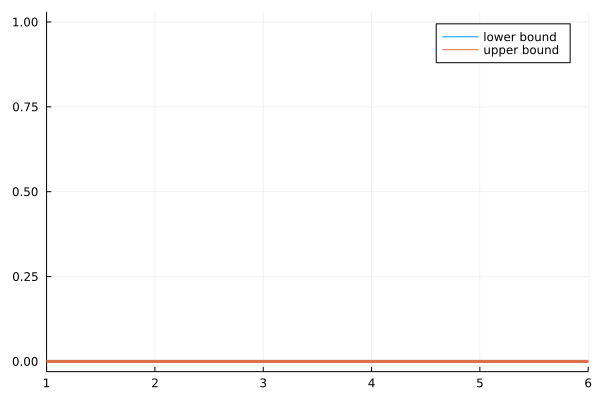

In [53]:
Ks = exp.(LinRange(0.0, exp(1), 20))
plot(Ks, [compute_lower_Y0(df; K=K, H =1) for K in Ks], xlim = (1, 6), label = "lower bound", lw = 3)
plot!(Ks, [compute_upper_Y0(df; K=K, H =1) for K in Ks], label = "upper bound", lw = 3)
plot!(leg = :best)
# hline!([mean(df[df.G .== 0, :Y0])], label = "oracle mean", linestyle = :dot, lw = 3)

In [54]:
function data_generation2(N = 10000; H = exp(0.1), K = exp(0.5))
    N = 10000 # number of total observations
    
    τ = 1
    
    # unobserved confounder for external validity
    U = rand(Normal(), N)
    
    # DGP for S₁ and G. They all depend on U.
    S₀ = 5 * (rand(N) .< (0.5 .- 0.45*(U.>0))) .+ 5 
    S₁ = 5 * (rand(N) .< (0.5 .- 0.3*(U.>0))) .+ 5 
    G = rand(N) .> (1 ./ (1 .+ exp.(-log(H).* (U.>0)))); 
    
    # unobserved confounder for latent unconfoundedness
    V = rand(Normal(), N);
    
    # DGP for Y₁ and D. They all depend on V.
    Y₀ = S₀ + V + randn(N);
    Y₁ = S₁ + V + randn(N) .+ τ;
    D = similar(G);
    
    # randomization in the experimental sample
    D[G .== 1] = rand((0,1), sum(G .== 1))
    
    # K-latent-confoundedness
    D[G .== 0] = rand(sum(G .== 0)) .> 
    (1 ./ (1 .+ exp.(-log(K).* (V[G .== 0].>0) .- 0.1 .*S₁[G .== 0])))
    
    df = DataFrame(G = G, S1 = S₁, S0 = S₀, D=D, Y1 = Y₁, Y0 = Y₀, 
        S = D.*S₁ .+ (1 .-D).*S₀, Y = D.*Y₁ .+ (1 .- D).* Y₀)
end

data_generation2 (generic function with 2 methods)

In [55]:
df2 = data_generation2(10000; H = 1, K = 1)

,G,S1,S0,D,Y1,Y0,S,Y
,Bool,Int64,Int64,Bool,Float64,Float64,Int64,Float64
1,0,5,10,1,4.39136,9.8833,5,4.39136
2,0,5,5,1,6.41366,6.03688,5,6.41366
3,1,10,5,0,9.14591,3.22397,5,3.22397
4,1,10,5,0,10.3817,4.51284,5,4.51284
5,0,5,5,0,5.91461,5.70892,5,5.70892
6,0,5,5,0,4.32703,3.66771,5,3.66771
7,0,5,10,0,6.02977,8.82119,10,8.82119
8,1,5,10,1,5.90311,8.14789,5,5.90311
9,0,10,5,1,11.1204,5.15118,10,11.1204


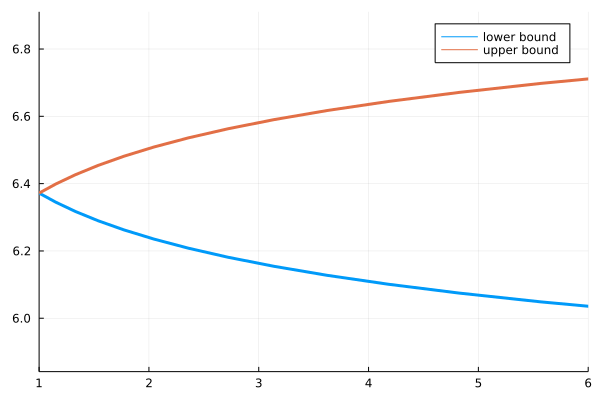

In [56]:
Ks = exp.(LinRange(0.0, exp(1), 20))
plot(Ks, [compute_lower_Y0(df2; K=K, H =1) for K in Ks], xlim = (1, 6), label = "lower bound", lw = 3)
plot!(Ks, [compute_upper_Y0(df2; K=K, H =1) for K in Ks], label = "upper bound", lw = 3)
plot!(leg = :best)
# hline!([mean(df[df.G .== 0, :Y0])], label = "oracle mean", linestyle = :dot, lw = 3)

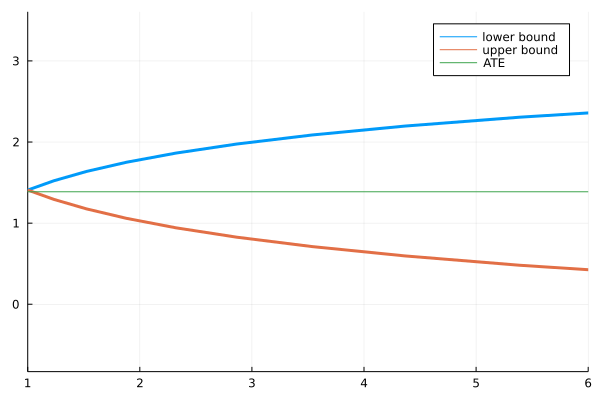

In [57]:
Ks = exp.(LinRange(0.0, 4, 20))
plot(Ks, [compute_upper_Y1(df2; K=K, H =1) - compute_lower_Y0(df2; K=K, H =1) for K in Ks], xlim = (1, 6), label = "lower bound", lw = 3)
plot!(Ks, [compute_lower_Y1(df2; K=K, H =1) - compute_upper_Y0(df2; K=K, H =1) for K in Ks], label = "upper bound", lw = 3)
plot!(leg = :best)
hline!([ mean(df2[df2.G .== 1, :Y1] - df2[df2.G .== 1, :Y0])], label = "ATE")

In [193]:
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for i in 1:100
    df2 = data_generation2(1000; K = 1, H = 1)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = 1, H = 1) - compute_lower_Y0(df2; K = 1, H = 1))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = 1, H = 1) - compute_upper_Y0(df2; K = 1, H = 1))
    push!(oracle_τ, mean(df2[df.G.==0, :Y1] - df2[df.G.==0, :Y0]))
end

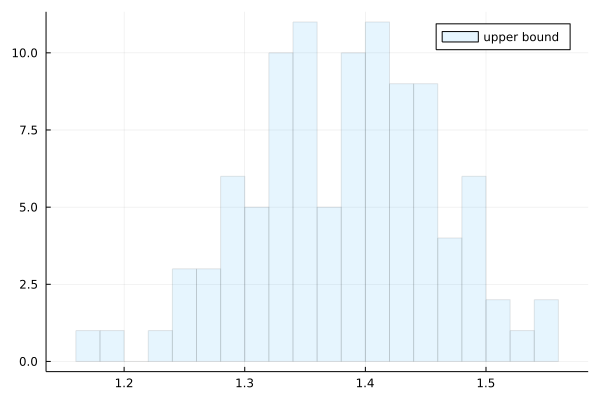

In [194]:
histogram(upper_bound_τ, bins = 20, alpha = 0.1, label = "upper bound")

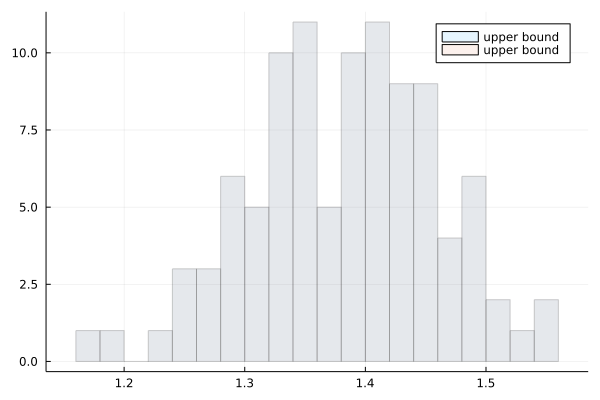

In [195]:
histogram!(lower_bound_τ, bins = 20, alpha = 0.1, label = "upper bound")

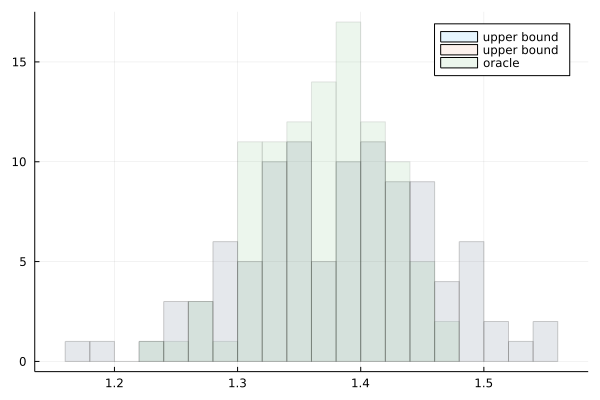

In [196]:
histogram!(oracle_τ, bins = 20, alpha = 0.1, label = "oracle")

# Inference

The asymptotic distribution of $\hat{\tau}^-$ could be given by the following expansion:
$$\hat{\tau}^{-} - \tau = \tilde{p}_1 (m_1 + m_0 - \mu_1^- - \mu_0^+) + (1- p_1)(\tilde{\mu}_1^- - \tilde{m}_0) + p_1 (\tilde{m}_1 - \tilde{\mu}_0^+) + o_p(\frac{1}{\sqrt{n}})$$
where $p_1 = P(D =1 \mid G = O)$, $\mu_1^- = \text{lower bound of } \mathbb{E}[Y(1) \mid D = 0, G = O]$, and $\mu_0^+ = \text{upper bound of } \mathbb{E}[Y(0) \mid D = 1, G = O]$. All the tilde terms are just estimator minus true value.

To apply delta method, we need to get the asymptotic distribution of $(\tilde{p}_1, \tilde{m}_0, \tilde{m}_1, \tilde{\mu}_0^+, \tilde{\mu}_1^-)$. The first three are easy. For the latter two, we need to first deduce the asymptotic behavior of $\hat{\theta}_1(s)$.

  

$\mathbb{E}_n\left[(Y-\hat{\theta}_1(s))_{+}-\Gamma(Y-\hat{\theta}_1(s))_{-} \mid S=s, D=1, G = O\right]  = 0$

What's the moment condition?

- $p_1 = P(D = 1 \mid G = O)$
- $\mathbb{E}\left[\mathbb{I}(S=s_1, D=1, G = O) \left((Y-\theta_1(s_1))_{+}-\Gamma(Y-\theta_1(s_1))_{-} \right)\right]  = 0$
- $\mathbb{E}\left[\mathbb{I}(S=s_2, D=1, G = O) \left((Y-\theta_1(s_2))_{+}-\Gamma(Y-\theta_1(s_2))_{-} \right)\right]  = 0$
- $\mathbb{E}\left[\mathbb{I}(D=1, G = E, S=s_1) \left((\theta_1(s_1)-\zeta_1^-))_{+} - H(\theta_1(s_1)-\zeta_1^-)_{-} \right) + \mathbb{I}(D=1, G = E, S=s_2) \left((\theta_1(s_2)-\zeta_1^-))_{+} - H(\theta_1(s_2)-\zeta_1^-)_{-} \right)\right]  = 0$
- $q_1 = P(S=s_1 \mid D=1, G=O)$
- $q_2 = P(S=s_2 \mid D=1, G=O)$
- $\mu_1^- (1-p_1) = \zeta_1^- - (\theta_1(s_1) q_1 + \theta_1(s_2) q_2) \times p_1$

## Primer on GMM

In [62]:
N = 10000
X = [ones(N) randn(N,2)]
ε = randn(N)

β₀ = [1, 2, 3]

Y = X * β₀ + ε;

data = [X Y];

In [63]:
function moment(param, data)
    X = data[:,1:end-1]
    Y = data[:,end]
    n = size(X, 1)

    β = param

    1/n * X' * (Y - X * β)
end

moment (generic function with 1 method)

In [64]:
function cov_moment(param, data)
    X = data[:,1:end-1]
    Y = data[:,end]
    n = size(X, 1)

    β = param

    result = zeros(3,3)
    for i in 1:n
        x = X[i,:]
        y = Y[i]
        mom = x * (y - x' * β)
        result += 1/n * mom * mom'
    end
    result

end

cov_moment (generic function with 1 method)

In [65]:
cov_moment([1,2,3], data)

3×3 Matrix{Float64}:
  1.00172      0.0204351   -0.00567254
  0.0204351    0.99191     -0.00875254
 -0.00567254  -0.00875254   0.99341

In [66]:
N * moment([1, 2, 3], data) * moment([1, 2, 3], data)'

3×3 Matrix{Float64}:
  0.747787   -0.264968    0.0520262
 -0.264968    0.0938881  -0.0184348
  0.0520262  -0.0184348   0.00361965

In [67]:
using LinearAlgebra
using Optim
using ForwardDiff

In [68]:
loss(β) = norm(moment(β, data))

result = Optim.optimize(loss, [1.0,1.0,1.0])
β̂ = result.minimizer

3-element Vector{Float64}:
 1.0086722195174196
 1.9968080424775394
 3.00053315809228

In [69]:
G = ForwardDiff.jacobian(x -> moment(x, data), β̂)
V = cov_moment(β̂, data)

inv(G' * inv(V) * G)

3×3 Matrix{Float64}:
  1.00151     0.0045783  -0.00678135
  0.0045783   1.03718     0.028444
 -0.00678135  0.028444    0.978265

## Back to our case

For lower bound of $\mathbb{E}[Y(1) \mid G = O]$: parameter = $(p_1, \theta_{1,1}, \theta_{1,2}, \zeta_1^-, q_1, q_2, m_1, \mu_1^-)$

- $p_1 = P(D = 1 \mid G = O)$
- $\mathbb{E}\left[\mathbb{I}(S=s_1, D=1, G = O) \left((Y-\theta_1(s_1))_{+}-\Gamma(Y-\theta_1(s_1))_{-} \right)\right]  = 0$
- $\mathbb{E}\left[\mathbb{I}(S=s_2, D=1, G = O) \left((Y-\theta_1(s_2))_{+}-\Gamma(Y-\theta_1(s_2))_{-} \right)\right]  = 0$
- $\mathbb{E}\left[\mathbb{I}(D=1, G = E, S=s_1) \left((\theta_1(s_1)-\zeta_1^-))_{+} - H(\theta_1(s_1)-\zeta_1^-)_{-} \right) + \mathbb{I}(D=1, G = E, S=s_2) \left((\theta_1(s_2)-\zeta_1^-))_{+} - H(\theta_1(s_2)-\zeta_1^-)_{-} \right)\right]  = 0$
- $q_1 = P(S=s_1 \mid D=1, G=O)$
- $q_2 = P(S=s_2 \mid D=1, G=O)$
- $m_1 = \mathbb{E}[Y \mid D = 1, G = O]$
- $\mu_1^- (1-p_1) = \zeta_1^- - (\theta_1(s_1) q_1 + \theta_1(s_2) q_2) \times p_1$

In [161]:
df2 = data_generation2()

,G,S1,S0,D,Y1,Y0,S,Y
,Bool,Int64,Int64,Bool,Float64,Float64,Int64,Float64
1,0,5,5,0,7.05618,4.53385,5,4.53385
2,0,5,5,1,5.34139,4.86849,5,5.34139
3,0,5,10,0,5.40829,8.44037,10,8.44037
4,0,10,5,0,12.5298,7.06678,5,7.06678
5,1,5,10,1,5.45006,11.3561,5,5.45006
6,0,10,10,0,12.4314,12.6397,10,12.6397
7,1,10,10,1,10.5818,9.79251,10,10.5818
8,1,5,5,0,5.57953,5.21036,5,5.21036
9,0,10,10,0,13.3365,9.87167,10,9.87167


In [351]:
K = 1;
H = 1;
ϕ(x, y; K = 1, H = 1) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
ϕ′(x, y; K = 1, H = 1) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
ψ(x, y; K = 1, H = 1) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
ψ′(x, y; K = 1, H = 1) = max.(x .- y, 0) .- K .* max.(y .- x, 0)

function moment_Y1lb(param, data)
    df = data
    p1, θ11, θ12, ζ1, q1, q2, m1, μ1 = param

    [p1 - mean(df[df.G.==0, :D])
        mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ11, df.Y))
        mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ12, df.Y))
        mean((df.D .== 1) .* (df.G .== 1) .* (df.S .== 5) .* ϕ(ζ1, θ11)) + mean((df.D .== 1) .* (df.G .== 1) .* (df.S .== 10) .* ϕ(ζ1, θ12))
        q1 - mean(df[(df.G.==0).*(df.D.==1), :S] .== 5)
        q2 - mean(df[(df.G.==0).*(df.D.==1), :S] .== 10)
        mean((df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1))
        μ1 * (1 - p1) - ζ1 + p1 * (q1 * θ11 + q2 * θ12)]
end

moment_Y1lb (generic function with 1 method)

In [163]:
function moment_Y0ub(param, data)
    df = data
    p1, θ11, θ12, ζ1, q1, q2, m1, μ1 = param

    [p1 - mean(df[df.G.==0, :D]);
     mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ11, df.Y));
     mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ12, df.Y));
     mean((df.D .== 1) .* (df.G .== 1) .* (df.S .== 5) .* ϕ(ζ1, θ11)) + mean((df.D .== 1) .* (df.G .== 1) .* (df.S .== 10) .* ϕ(ζ1, θ12));
     q1 - mean(df[ (df.G.==0) .* (df.D .==1), :S] .== 5);
     q2 - mean(df[ (df.G.==0) .* (df.D .==1), :S] .== 10);
     mean((df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1));
     μ1 * (1 - p1) - ζ1 + p1 * (q1 * θ11 + q2 * θ12)]
end

moment_Y0ub (generic function with 1 method)

In [164]:
param_init = [0.5, 5.0, 10.0, 7.5, 0.3, 0.3, 7.0, 5.0]
moment_Y1lb(param_init, df2)

8-element Vector{Float64}:
  0.20805236017453393
  0.1012390444218417
  0.03791311141564053
 -0.17825
 -0.4282608695652174
  0.028260869565217395
  0.044752155837482224
 -2.75

In [165]:
function cov_moment_Y1lb(param, data)
    df = data
    p1, θ11, θ12, ζ1, q1, q2, m1, μ1 = param

    n = size(df, 1)

    mom = hcat(p1 .- (df.G .== 0) .* df[:, :D],
        (df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ11, df.Y),
        (df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ12, df.Y),
        (df.D .== 1) .* (df.G .== 1) .* (df.S .== 5) .* ϕ(ζ1, θ11) + (df.D .== 1) .* (df.G .== 1) .* (df.S .== 10) .* ϕ(ζ1, θ12),
        q1 .- (df.G .== 0) .* (df.D .== 1) .* (df[:, :S] .== 5),
        q2 .- (df.G .== 0) .* (df.D .== 1) .* (df[:, :S] .== 10),
        (df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1),
        ones(n,1) .* (μ1 * (1 - p1) - ζ1 + p1 * (q1 * θ11 + q2 * θ12)))

    result = zeros(8,8)
    for i in 1:n
        result += 1/n * mom[i,:] * mom[i,:]'
    end

    result
end

cov_moment_Y1lb (generic function with 1 method)

In [166]:
loss(param) = norm(moment_Y1lb(param, df2))

result = Optim.optimize(loss, param_init)
param_est = result.minimizer

8-element Vector{Float64}:
  0.29194763715285754
  5.944394024362036
 10.947827971947838
  7.722490767006813
  0.7282608669485426
  0.27173913860594884
  7.304022773522749
  7.895035459566242

In [167]:
diag(cov_moment_Y1lb(param_est, df2))

8-element Vector{Float64}:
 0.14648403846134606
 0.23092673275979833
 0.07857150194489601
 1.4136679808603534
 0.481424760454911
 0.09210302836181658
 1.0387597036315857
 9.690323524518373e-16

In [168]:
G = ForwardDiff.jacobian(x -> moment_Y1lb(x, df2), param_est)[1:7, 1:7]
V = cov_moment_Y1lb(param_est, df)[1:7, 1:7]

diag(inv(G' * inv(V) * G))

7-element Vector{Float64}:
  0.14796366033846958
 30.57297995781876
 72.29908372294341
 44.62583062019565
  0.4823013358702173
  0.09156705963809897
 55.72789115646258

In [169]:
μ1func((p1, θ11, θ12, ζ1, q1, q2)) = (ζ1 - p1 * (q1 * θ11 + q2 * θ12)) / (1 - p1)

p1hat, θ11hat, θ12hat, ζ1hat, q1hat, q2hat, m1hat = param_est[1:7]

7-element Vector{Float64}:
  0.29194763715285754
  5.944394024362036
 10.947827971947838
  7.722490767006813
  0.7282608669485426
  0.27173913860594884
  7.304022773522749

In [170]:
μ1func(param_est[1:end-1]) * (1 - p1hat) + p1hat * m1hat

7.722490733477766

In [171]:
y1lb_func((p1, θ11, θ12, ζ1, q1, q2, m1)) = μ1func((p1, θ11, θ12, ζ1, q1, q2)) * (1 - p1) + p1 * m1

y1lb_func (generic function with 1 method)

In [172]:
Y1lb = y1lb_func(param_est[1:7])

7.722490733477766

Now, apply delta method!

In [173]:
asym_var_Y1lb = ForwardDiff.gradient(y1lb_func, param_est[1:7])' * inv(G' * inv(V) * G) * ForwardDiff.gradient(y1lb_func, param_est[1:7])

49.39058199688289

In [174]:
std_err_Y1lb = sqrt(asym_var_Y1lb) / sqrt(size(df2, 1))

0.07027843338954198

In [175]:
(Y1lb - 1.96 * std_err_Y1lb, Y1lb + std_err_Y1lb)

(7.584745004034264, 7.792769166867308)

In [176]:
mean(df2[ df.G .== 0, :Y1 ])

7.734952138525636

In [352]:
function moment_τ_bds(param, data; K = 1, H = 1)
    df = data
    p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0 = param

    [p1 - mean(df[df.G.==0, :D])
        mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ11, df.Y; K = K, H = H))
        mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ12, df.Y; K = K, H = H))
        mean((df.D .== 1) .* (df.G .== 1) .* (df.S .== 5) .* ϕ(ζ1, θ11; K = K, H = H)) + mean((df.D .== 1) .* (df.G .== 1) .* (df.S .== 10) .* ϕ(ζ1, θ12; K = K, H = H))
        mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ′(θ01, df.Y; K = K, H = H))
        mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ′(θ02, df.Y; K = K, H = H))
        mean((df.D .== 0) .* (df.G .== 1) .* (df.S .== 5) .* ϕ′(ζ0, θ01; K = K, H = H)) + mean((df.D .== 0) .* (df.G .== 1) .* (df.S .== 10) .* ϕ′(ζ0, θ02; K = K, H = H))
        q1 - mean(df[(df.G.==0).*(df.D.==1), :S] .== 5)
        # q2 - mean(df[ (df.G.==0) .* (df.D .==1), :S] .== 10);
        r1 - mean(df[(df.G.==0).*(df.D.==0), :S] .== 5)
        # r2 - mean(df[ (df.G.==0) .* (df.D .==0), :S] .== 10);
        mean((df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1))
        mean((df.D .== 0) .* (df.G .== 0) .* (df.Y .- m0))]
end

moment_τ_bds (generic function with 1 method)

In [353]:
param_init = [0.5, 5.0, 10.0, 7.5, 5.0, 10.0, 7.5, 0.3, 0.3, 7.0, 8.0]
moment_τ_bds(param_init, df2)

11-element Vector{Float64}:
  0.19550359712230214
  0.10875730665126734
  0.03714499642170084
 -0.153
 -0.016948065733719538
 -0.008578881963859135
  0.21949999999999997
 -0.4477849970466627
 -0.4447633824670287
  0.020802303072968202
 -0.6410730523024214

In [354]:
loss(param) = norm(moment_τ_bds(param, df2))

result = Optim.optimize(loss, param_init)
param_est = result.minimizer

11-element Vector{Float64}:
  0.3044964051559941
  5.8590624808484755
 10.86990589331224
  7.682403219067957
  5.058847492851429
 10.08691914129269
  6.565892741100091
  0.7477850072207478
  0.7447634102799022
  7.1228725054835
  6.342195380105399

In [355]:
function cov_moment_τ_bds(param, data; K = 1, H = 1)
    df = data
    p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0 = param

    n = size(df, 1)

    mom = hcat((df.G .== 0) .* (p1 .- df[:, :D]),
        (df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ11, df.Y; K = K, H = H),
        (df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ12, df.Y; K = K, H = H),
        (df.D .== 1) .* (df.G .== 1) .* (df.S .== 5) .* ϕ(ζ1, θ11; K = K, H = H) + (df.D .== 1) .* (df.G .== 1) .* (df.S .== 10) .* ϕ(ζ1, θ12; K = K, H = H),
        (df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ′(θ01, df.Y; K = K, H = H),
        (df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ′(θ02, df.Y; K = K, H = H),
        (df.D .== 0) .* (df.G .== 1) .* (df.S .== 5) .* ϕ′(ζ0, θ01; K = K, H = H) + (df.D .== 0) .* (df.G .== 1) .* (df.S .== 10) .* ϕ′(ζ0, θ02; K = K, H = H),
        (df.G .== 0) .* (df.D .== 1) .* (q1 .- (df[:, :S] .== 5)),
        # (df.G .== 0) .* (df.D .== 1) .* (q2 .- (df[:, :S] .== 10)),
        (df.G .== 0) .* (df.D .== 0) .* (r1 .- (df[:, :S] .== 5)),
        # (df.G .== 0) .* (df.D .== 0) .* (r2 .- (df[:, :S] .== 10)),
        (df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1),
        (df.D .== 0) .* (df.G .== 0) .* (df.Y .- m0))

    result = zeros(11, 11)
    for i in 1:n
        result += 1 / n * mom[i, :] * mom[i, :]'
    end

    result
end

cov_moment_τ_bds (generic function with 1 method)

In [356]:
diag(cov_moment_τ_bds(param_est, df2))

11-element Vector{Float64}:
 0.11774875899281606
 0.2476161383219711
 0.09043909848718495
 1.306515892816204
 0.5677010193463515
 0.20918327454685878
 1.1631510439143558
 0.03193041937389311
 0.07350814584949494
 1.1397819419931203
 2.635280566223897

In [357]:
p1hat, θ11hat, θ12hat, ζ1hat, θ01hat, θ02hat, ζ0hat, q1hat, r1hat, m1hat, m0hat = param_est[1:11];
mean(df2[(df2.G.==0).*(df2.D.==1), :S] .== 5)


0.7477849970466627

In [358]:
τ_lb_func((p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0)) = (ζ1 - p1 * (q1 * θ11 + (1-q1) * θ12)) + p1 * m1 -
                ( (ζ0 - (1 - p1) * (r1 * θ01 + (1-r1) * θ02)) + (1 - p1) * m0 )


τ_lb_func (generic function with 1 method)

In [359]:
τ_lb_func(param_est[1:11])

1.1165105170172929

In [360]:
G = ForwardDiff.jacobian(x -> moment_τ_bds(x, df2), param_est)[1:11, 1:11]
V = cov_moment_τ_bds(param_est, df2)[1:11, 1:11]
diag(V)

11-element Vector{Float64}:
 0.11774875899281606
 0.2476161383219711
 0.09043909848718495
 1.306515892816204
 0.5677010193463515
 0.20918327454685878
 1.1631510439143558
 0.03193041937389311
 0.07350814584949494
 1.1397819419931203
 2.635280566223897

In [361]:
grad_τ_lb = ForwardDiff.gradient(τ_lb_func, param_est[1:11])

11-element Vector{Float64}:
  2.1638002589696725e-7
 -0.22769784652826677
 -0.07679855862772729
  1.0
  0.5179856291579533
  0.17751796568605266
 -1.0
  1.52578380589481
 -3.497041906624123
  0.3044964051559941
 -0.6955035948440059

In [362]:
asym_var_τ_lb = grad_τ_lb'  * inv(G' * inv(V) * G) * grad_τ_lb

72.28606102583633

In [363]:
std_err_τ_lb = sqrt(asym_var_τ_lb) / sqrt(size(df2, 1))

0.08502120972194899

In [364]:
(τ_lb_func(param_est[1:11]) - 1.96 * std_err_τ_lb, τ_lb_func(param_est[1:11]) + 1.96 * std_err_τ_lb)

(0.9498689459622729, 1.2831520880723128)

In [365]:
mean(df2[df2.G.==0, :Y1]) - mean(df2[df2.G.==0, :Y0])

1.404274483520755

In [366]:
mean(df2[(df2.G.==0).*(df2.D.==1), :Y]) - mean(df2[(df2.G.==0).*(df2.D.==0), :Y])

0.7806770688462343

In [367]:
lb1 = compute_lower_Y1(df2; K=1, H =1) - compute_upper_Y0(df2; K=1, H =1)

1.1165107499854567

In [368]:
(lb1 - 1.96 * std_err_τ_lb, lb1 + 1.96 * std_err_τ_lb)

(0.9498691789304368, 1.2831523210404767)

In [369]:
 (ζ1hat - p1hat * (q1hat * θ11hat + (1-q1hat) * θ12hat)) + p1hat * m1hat

7.682403276782971

In [370]:
compute_lower_Y1(df2; K=1, H =1)

7.68240329748768

In [371]:
 ( (ζ0hat - (1 - p1hat) * (r1hat * θ01hat + (1-r1hat) * θ02hat)) + (1 - p1hat) * m0hat )

6.565892759765678

In [372]:
compute_upper_Y0(df2; K=1, H =1)

6.565892547502223

In [373]:
function CI_τ_lb(data; K = 1, H = 1)

    param_init = [0.5, 5.0, 10.0, 7.5, 5.0, 10.0, 7.5, 0.3, 0.3, 7.0, 8.0]

    loss(param) = norm(moment_τ_bds(param, data))
    result = Optim.optimize(loss, param_init)
    param_est = result.minimizer

    τ_lb_func((p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0)) = (ζ1 - p1 * (q1 * θ11 + (1 - q1) * θ12)) + p1 * m1 -
                                                                  ((ζ0 - (1 - p1) * (r1 * θ01 + (1 - r1) * θ02)) + (1 - p1) * m0)

    G = ForwardDiff.jacobian(x -> moment_τ_bds(x, data), param_est)[1:11, 1:11]
    V = cov_moment_τ_bds(param_est, data)[1:11, 1:11]

    grad_τ_lb = ForwardDiff.gradient(τ_lb_func, param_est[1:11])

    asym_var_τ_lb = grad_τ_lb' * inv(G' * inv(V) * G) * grad_τ_lb

    std_err_τ_lb = sqrt(asym_var_τ_lb) / sqrt(size(df2, 1))

    return (τ_lb_func(param_est[1:11]) - 1.96 * std_err_τ_lb, τ_lb_func(param_est[1:11]) + 1.96 * std_err_τ_lb), mean(df2[df2.G.==0, :Y1]) - mean(df2[df2.G.==0, :Y0])
end

CI_τ_lb (generic function with 1 method)

In [392]:
df2 = data_generation2(100, K = exp(1), H =1)
CI_τ_lb(df2, K = exp(1), H = 1)

((0.9416353379915735, 1.2600477518609208), 1.3347733572398974)

In [398]:
result = 0.0

for i in 1:100
    df2 = data_generation2(100; K = exp(1), H = 1)
    CI, oracle_est = CI_τ_lb(df2; K = exp(1), H = 1)
    result += (oracle_est > CI[1]) 

    if (i % 5 == 0)
        println("Finished simulation #$i !")
    end
end

result

Finished simulation #5 !
Finished simulation #10 !
Finished simulation #15 !
Finished simulation #20 !
Finished simulation #25 !
Finished simulation #30 !
Finished simulation #35 !
Finished simulation #40 !
Finished simulation #45 !
Finished simulation #50 !
Finished simulation #55 !
Finished simulation #60 !
Finished simulation #65 !
Finished simulation #70 !
Finished simulation #75 !
Finished simulation #80 !
Finished simulation #85 !
Finished simulation #90 !
Finished simulation #95 !
Finished simulation #100 !


100.0

In [350]:
result # 93.0% is pretty good, isn't it?

100.0